In [1]:
token='YOUR_TRAVELPAYOUTS_TOKEN'

In [296]:
import requests
import json
import pandas as pd

response_API = requests.get('http://api.travelpayouts.com/v1/city-directions?origin=ATH&currency=eur&token='+token)
data = response_API.text
parse_json = json.loads(data)
dest=list(parse_json['data'].keys())
#print(dest)

#for p in range(1,30):
response_API = requests.get(
    'https://api.travelpayouts.com/v2/prices/latest?currency=eur&period_type=year&origin=ATH&destination=MOW&page=1&limit=1000&show_to_affiliates=true&token='+token)
#print(response_API.status_code)
data = response_API.text
parse_json = json.loads(data)

#load data to pandas dataframe
#if p==1:
df = pd.json_normalize(parse_json['data'])
#else:
#    df = df.append(pd.json_normalize(parse_json['data']), ignore_index=True)

df = df.sort_values('found_at')
df

,value,trip_class,show_to_affiliates,origin,destination,gate,depart_date,return_date,number_of_changes,found_at,duration,distance,actual
32,179,0,True,ATH,MOW,,2022-04-08,2022-05-07,0,2022-03-03T08:18:29,490,2241,True
50,202,0,True,ATH,MOW,KupiBilet.ru,2022-03-18,2022-03-27,2,2022-03-03T08:27:17,1025,2206,True
238,620,0,True,ATH,MOW,,2022-03-10,2022-03-24,1,2022-03-03T08:56:57,805,2202,True
46,196,0,True,ATH,MOW,Aviakassa,2022-03-25,2022-04-01,1,2022-03-03T11:16:02,1810,2202,True
126,283,0,True,ATH,MOW,,2022-06-15,2022-07-01,0,2022-03-03T11:33:36,490,2241,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,1122,0,True,ATH,MOW,SmartFares,2022-03-11,2022-03-12,1,2022-03-10T07:52:14,2330,2241,True
248,741,0,True,ATH,MOW,SmartFares,2022-03-10,2022-04-04,1,2022-03-10T08:04:52,1910,2202,True
57,217,0,True,ATH,MOW,KLM,2022-07-01,2022-07-08,1,2022-03-10T08:06:30,1150,2241,True
87,254,0,True,ATH,MOW,OneTwoTrip,2022-05-22,2022-05-23,1,2022-03-10T08:37:24,2595,2206,True


In [297]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['gate']= label_encoder.fit_transform(df['gate'])
#df['origin']= label_encoder.fit_transform(df['origin'])
#df['destination']= label_encoder.fit_transform(df['destination'])
#one_hot = pd.get_dummies(df.gate, prefix='gate')
#df = df.drop('gate',axis = 1)
#df = df.join(one_hot)

df['depart_date']= pd.to_datetime(df['depart_date'])
df['found_at']= pd.to_datetime(df['found_at'])

#df['depart_year'] = df['depart_date'].dt.year
df['depart_month'] = df['depart_date'].dt.month
df['depart_week'] = df['depart_date'].dt.week
df['depart_day'] = df['depart_date'].dt.day
df['depart_dayofweek'] = df['depart_date'].dt.dayofweek
df['time_until_departure']=(df['depart_date']-df['found_at']).astype('timedelta64[s]')
df['min_price']=df.groupby(['depart_month','depart_week','depart_day'])['value'].transform('min')
df['max_price']=df.groupby(['depart_month','depart_week','depart_day'])['value'].transform('max')
df['last_offer']=df.groupby(['depart_month','depart_week','depart_day'])['time_until_departure'].transform('min')

del df['depart_date']
del df['found_at']
del df['trip_class']
del df['number_of_changes']
del df['show_to_affiliates']
del df['actual']
del df['return_date']
del df['duration']
del df['distance']
del df['origin']
del df['destination']

train=df[:240]
test=df[240:]

train

/tmp/ipykernel_2493/2355012556.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['depart_week'] = df['depart_date'].dt.week


,value,gate,depart_month,depart_week,depart_day,depart_dayofweek,time_until_departure,min_price,max_price,last_offer
32,179,0,4,14,8,4,3080491.0,179,227,2923817.0
50,202,10,3,11,18,4,1265563.0,202,1988,681437.0
238,620,0,3,10,10,3,572583.0,282,926,-29092.0
46,196,3,3,12,25,4,1860238.0,175,947,1271087.0
126,283,0,6,24,15,2,8943984.0,283,283,8943984.0
...,...,...,...,...,...,...,...,...,...,...
209,481,0,3,12,27,6,1493671.0,238,1363,1493671.0
214,489,10,3,10,12,5,196317.0,261,1720,147609.0
105,270,5,4,17,30,5,4428531.0,238,270,4419729.0
267,1454,21,3,10,12,5,194815.0,261,1720,147609.0


In [337]:
# Required for Env definition:
# 1. Action space
# 2. Observation space
#    The observation is a value representing the agent's current position/state. The number of possible observations is actually the number of possible states.
# 3. step method accepting action as a param and returning observation (state after action), reward (for transition to new observational state), done (boolean flag).
# 4. reset method that implements logic of fresh start of episode.

class Environment1:
    
    def __init__(self, data, n):
        self.data = data
        self.observation_size = n
        self.action_size = 2
        self.reset()
        
    def reset(self):
        self.t = 0 # index for observation/state
        self.done = False
        return self.data.iloc[self.t, :] # observation
    
    def step(self, act):
        # act = 0: wait, 1: buy
        if act == 0:
            if self.data.iloc[self.t, :]['value']>self.data.iloc[self.t, :]['min_price']:
                # as far away I am from min_price the largest reward I will have for waiting
                reward=self.data.iloc[self.t, :]['value']-self.data.iloc[self.t, :]['min_price']
            else:
                reward = -100000
        elif act == 1:
            if self.data.iloc[self.t, :]['value']>self.data.iloc[self.t, :]['min_price']:
                reward = -1000000 #self.data.iloc[self.t, :]['min_price']-self.data.iloc[self.t, :]['value'] # 
            else:
                # as far away is value from max_price the largest the reward
                reward = self.data.iloc[self.t, :]['max_price']-self.data.iloc[self.t, :]['value']
        #elif act == 0 and self.data.iloc[self.t,:]['time_until_departure']==self.data.iloc[self.t,:]['last_offer']:# if we wait and this particular flight sells out
        #    reward = -200000
        
        # set next time
        self.t += 1
        if self.t==self.observation_size-1:
            self.done=True
        
        return self.data.iloc[self.t, :], reward, self.done

In [350]:
# learn
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.losses import MeanSquaredError
import numpy as np

discount_factor = 1.00
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 250
num_episodes = 10

env = Environment1(train, 240)

model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 10)))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

mse=MeanSquaredError()

total_rewards = []
losses = []
q_values = []

for i in range(num_episodes):
    state = env.reset()

    done = False
    while not done:
        state_reshaped = np.array(state, dtype=np.float32).reshape(1, -1)
                
        # Take learned path or explore new actions based on the epsilon
        if np.random.random() < epsilon:
            action = np.random.randint(0, env.action_size)
        else:
            action = np.argmax(model.predict(state_reshaped))
        
        # Take action
        new_state, reward, done = env.step(action)
        
        # Recalculate
        new_state_reshaped = np.array(new_state, dtype=np.float32).reshape(1, -1)
        target = reward + discount_factor * np.max(model.predict(new_state_reshaped))
        target_vector = model.predict(state_reshaped)[0]
        qs = target_vector.copy()
        #print(target_vector[action], target)
        target_vector[action] = target
        model.fit(state_reshaped, target_vector.reshape(-1, env.action_size), epochs=1, verbose=0)
        state = new_state
        
        total_rewards.append(reward)
        losses.append(mse(target_vector,qs))
        q_values.append(target_vector)
        
        if epsilon > epsilon_min and len(total_rewards) > start_reduce_epsilon:
            epsilon -= epsilon_decrease

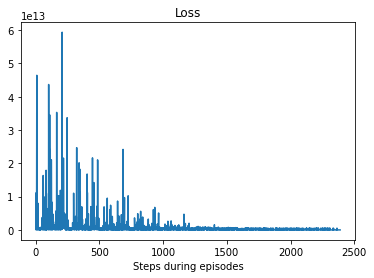

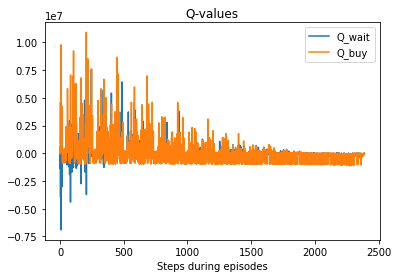

In [351]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Loss')
plt.xlabel('Steps during episodes')
plt.savefig('loss.png')
plt.show()

#plt.plot(total_rewards)
#plt.title('Reward')
#plt.xlabel('Steps during episodes')
#plt.savefig('reward.png')
#plt.show()

plt.plot(np.array(q_values)[:,0], label='Q_wait')
plt.plot(np.array(q_values)[:,1], label='Q_buy')
plt.title('Q-values')
plt.xlabel('Steps during episodes')
plt.legend(loc='upper right')
plt.savefig('q.png')
plt.show()

In [366]:
# train accuracy
decisions=[]
savings=[]
init_price=train.iloc[0, :]['value']
for i in range(210, 240):
    state=train.iloc[i, :]
    state_reshaped = np.array(state, dtype=np.float32).reshape(1, -1)
    action = np.argmax(model.predict(state_reshaped))
    if action==1 and state['value']==state['min_price']:
        decisions.append("correct")
        savings.append((init_price-state['value'])/state['value'])
    elif action==0 and state['value']>state['min_price']:
        decisions.append("correct")
        savings.append((state['value']-state['min_price'])/state['min_price'])
    elif action==1:
        decisions.append("wrong")
        savings.append(-(state['value']-state['min_price'])/state['min_price'])
    elif action==0:
        decisions.append("wrong")
        savings.append(-(init_price-state['min_price'])/state['min_price'])

In [367]:
print("Μέσο κέρδος από τις αποφάσεις:",np.mean(savings)*100,'%')
print("Μέγιστο κέρδος:",max(savings)*100,'%')
print("Mέγιστη ζημία:", min(savings)*100,'%')
print("Ποσοστό σωστών αποφάσεων:",decisions.count('correct')/len(decisions)*100,'%')

Μέσο κέρδος από τις αποφάσεις: 123.2880300869266 %
Μέγιστο κέρδος: 681.7567567567568 %
Mέγιστη ζημία: -17.763157894736842 %
Ποσοστό σωστών αποφάσεων: 76.66666666666667 %


In [354]:
# test accuracy
decisions=[]
savings=[]
init_price=test.iloc[0, :]['value']
for i in range(0, 32):
    state=test.iloc[i, :]
    state_reshaped = np.array(state, dtype=np.float32).reshape(1, -1)
    action = np.argmax(model.predict(state_reshaped))
    if action==1 and state['value']==state['min_price']:
        decisions.append("correct")
        savings.append((init_price-state['value'])/state['value'])
    elif action==0 and state['value']>state['min_price']:
        decisions.append("correct")
        savings.append((state['value']-state['min_price'])/state['min_price'])
    elif action==1:
        decisions.append("wrong")
        savings.append(-(state['value']-state['min_price'])/state['min_price'])
    elif action==0:
        decisions.append("wrong")
        savings.append(-(init_price-state['min_price'])/state['min_price'])

In [355]:
print("Μέσο κέρδος από τις αποφάσεις:",np.mean(savings)*100,'%')
print("Μέγιστο κέρδος:",max(savings)*100,'%')
print("Mέγιστη ζημία:", min(savings)*100,'%')
print("Ποσοστό σωστών αποφάσεων:",decisions.count('correct')/len(decisions)*100,'%')

Μέσο κέρδος από τις αποφάσεις: 216.00400629904408 %
Μέγιστο κέρδος: 1232.7338129496402 %
Mέγιστη ζημία: -493.1034482758621 %
Ποσοστό σωστών αποφάσεων: 87.5 %
